# Get started with the MSBM..

The purpose of this notebook is to demonstrate an example call to the main function, with parameters set, and outputs read into a simple plot. 

This way, readers who would like to apply our method on their own data would have a potentially modifiable example, where they can make some minimal changes to parameters and to read in their own data, and then could get started using the MSBM. 


## Synthetic data example
All parameters are defined in main.py and the model is run by calling the main function:
(for parameter definitions, see Figure 2 in the paper or main.py)

The generated synthetic data is visualized in visualize.ipynb

### Training model

In [5]:
import os
import numpy as np
from helper_functions import *
import matplotlib.pyplot as plt 

# data parameters
dataset = 'synthetic'
K = 5
Nc_type = 'unbalanced'
alpha = 0

# training parameters
noc = 50
maxiter_gibbs = 10

# misc
main_dir = os.getcwd()

%run -i 'main.py' --dataset {dataset} --K {K} --Nc_type {Nc_type} --alpha {alpha} --noc {noc} --maxiter_gibbs {maxiter_gibbs} --main_dir {main_dir}
# OBS! synthetic data is currrently only created for N=100, S1=5 and S2=5.

Namespace(dataset='synthetic', N=100, K=5, S1=5, S2=5, Nc_type='unbalanced', alpha=0.0, model_type='parametric', noc=50, splitmerge=False, maxiter_gibbs=10, maxiter_eta0=10, maxiter_alpha=100, maxiter_splitmerge=10, unit_test=False, matlab_compare=False, use_convergence_criteria=False, main_dir='/Users/Nina/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Article/ConnDiff-MSBM', save_dir='/Users/Nina/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Article/ConnDiff-MSBM/results/synthetic/synthetic_2024-05-20 11:56:23.003425', disp=True, sample_step=1, save_step=10, threshold_annealing=False)
Using synthetic dataset
Uni-partite clustering based on the MSBM for multiple graphs
-------------+--------------+--------------+--------------+--------------
Iteration    | logP         | dlogP/|logP| | noc          | time        
-------------+--------------+--------------+--------------+--------------
           1 |  -5.0651e+04 |          inf |            5 |       0.1027
    

### Results

In [26]:
exp_name = 'synthetic_2024-05-20 11:41:59.193410' # <-- change to the name of the experiment you want to evaluate!

save_dir = os.path.join(main_dir, 'results', dataset, exp_name)

# extract results
model_sample = np.load(os.path.join(main_dir, 'results',dataset,exp_name,'model_sample'+str(maxiter_gibbs)+'.npy'), allow_pickle=True).item()
print('model_sample keys:', model_sample.keys())


model_sample keys: dict_keys(['iter', 'Z', 'noc', 'logP_A', 'logP_Z', 'logP', 'eta', 'alpha', 'eta0', 'MAP'])


#### Convergence plot (log likelihood)

Text(0.5, 1.0, 'Log likelihood')

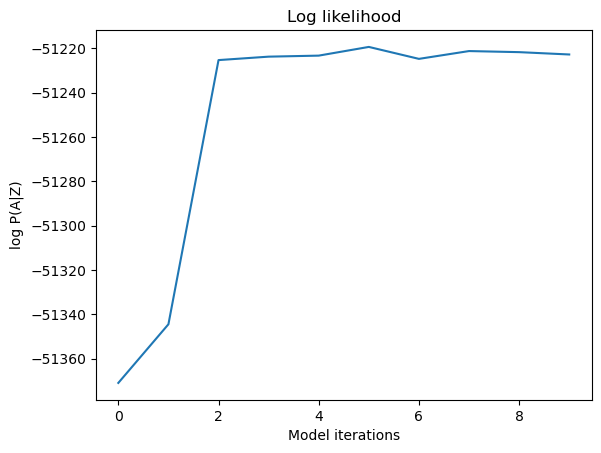

In [25]:
plt.plot(model_sample['logP_A'], label='logP_A')
plt.ylabel('log P(A|Z)')
plt.xlabel('Model iterations')
plt.title('Log likelihood')

#### MAP solution outputs

In [ ]:
# extracting MAP solution
MAP_sample = model_sample['MAP']

iter = MAP_sample['iter']
Z = MAP_sample['Z']
noc = MAP_sample['noc']
logP_A = MAP_sample['logP_A']
logP_Z = MAP_sample['logP_Z']
logP = MAP_sample['logP']
eta = MAP_sample['eta']

print('MAP logP(Z|A) =', logP)
print('MAP logP(A|Z) =', logP_A)
print('MAP logP(Z) =', logP_Z)
print('MAP noc =', noc)

##### MAP partition matrix Z

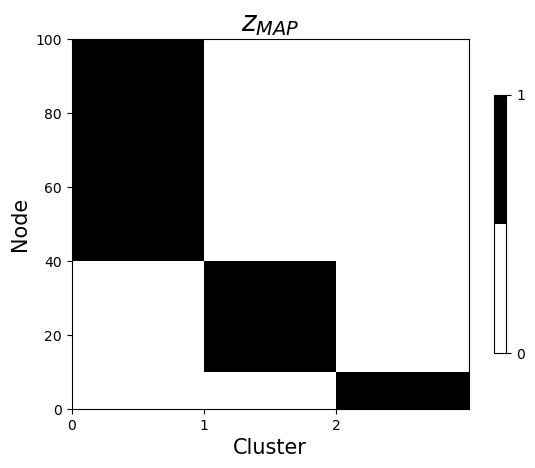

In [8]:
plot_ZMAP(Z,dataset=dataset)

##### Cluster-link probability matrices

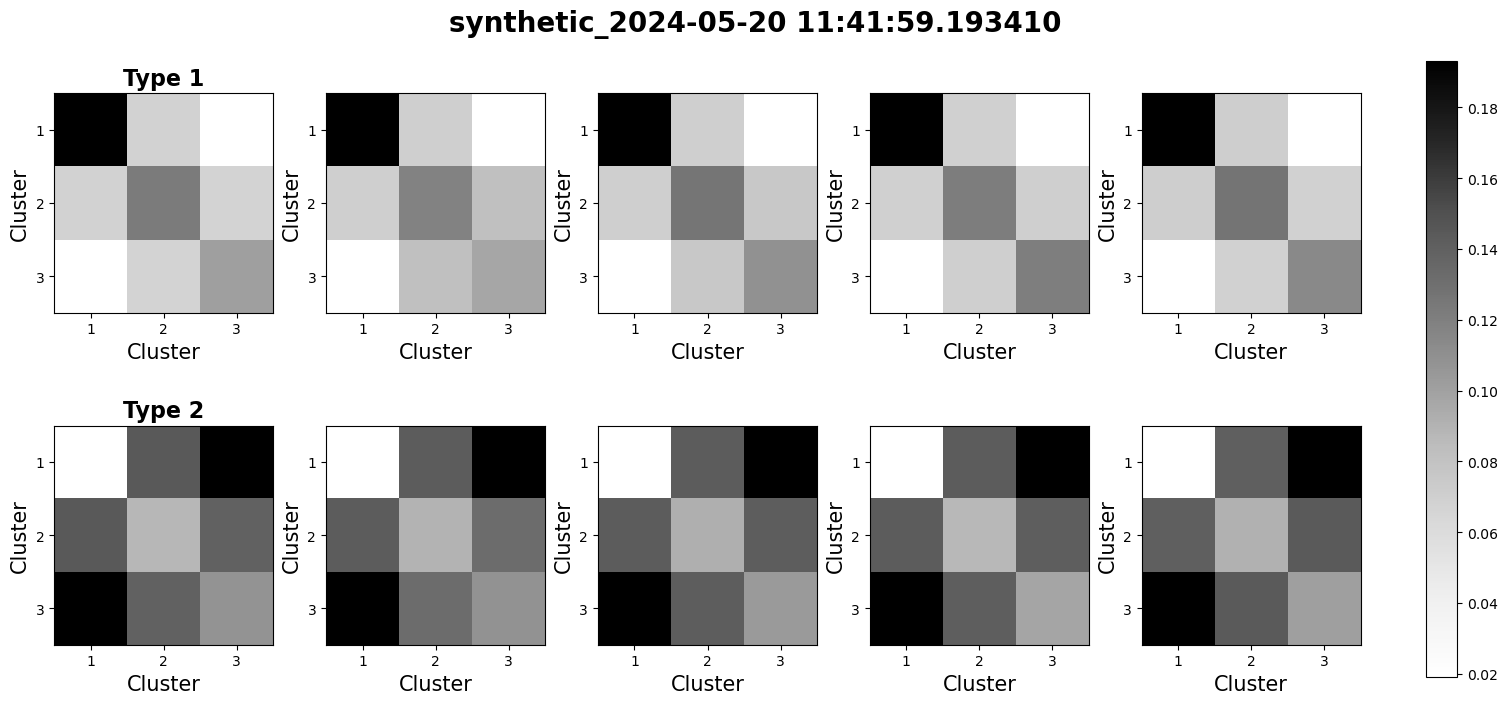

In [9]:
plot_eta(dataset=dataset, eta=eta, exp_name_title=exp_name)

### Computing connectomes for functional data

Set paths to subjectlist and top-path for functional data, in this case HCP data

Data can be downloaded using aws s3 by running the following command: 

aws s3 cp s3://hcp-openaccess/HCP1200/ /path/to/data/ --exclude "*" --include "**/*rfMRI_REST1_RL_Atlas_MSMAll_hp2000_clean.dtseries.nii*"

If interested in also evaluating structural connectomes, these would need to be computed separately.

In [ ]:
import nibabel as nib
from scipy import sparse
#replace with the path to subjectIDs
subjectIds = np.loadtxt('', dtype=int)
data_path = 'data/raw'

In [ ]:
def threshold_edges_density(W, desired_density, weight_to_remove='weakest'):
    """
    This function takes a weight matrix W and a desired density and returns a thresholded weight matrix W.
    """
    current_density = 1
 
    if float(desired_density) > current_density:
        raise ValueError('Desired density is larger than the current density')
 
    # Compute the threshold for the matrix W
    threshold = np.percentile(W, 100*(1-(float(desired_density)/current_density)))
 
    # Apply the threshold to the upper triangular matrix W
    
    if weight_to_remove == 'weakest':
        keep_these_elements = W >= threshold
    elif weight_to_remove == 'strongest':
        keep_these_elements = W < threshold
    W = W*keep_these_elements
 
    return W

In [ ]:
# In the below, "Networks" means groups of 50 subjects
for networkNr in range(1, 6):
    print(f'Operating on network {networkNr}')
    networkIds = subjectIds[(networkNr-1)*50:networkNr*50]
    density = np.zeros(len(networkIds))
    
    for tt, t in enumerate(networkIds):
        print(f'Operating on subject {t}')
 
        # For functional data we load the time series data.
        # If structural data we would have loaded the connectome data using functions from
        # the connectome-spatial-smoothing python package.
        
        # replace this path with the path to the data
        data = nib.load(data_path+'/'+str(t)+'/fMRI/rfMRI_REST1_RL_Atlas_MSMAll_hp2000_clean.dtseries.nii')
 
        # retain only cortical information
        data = np.array(data.dataobj)[:,:59412]
        data = (data - np.mean(data, axis=0))/np.std(data, axis=0)
        
        # compute correlation matrix
        data = (data.T@data)/(data.shape[0]-1)
 
        # threshold and binarize the correlation matrix
        data = threshold_edges_density(data, 0.001)
        data[data>0] = 1
 
        # convert to sparse matrix
        data = sparse.csr_matrix(data)
        if tt==0:
            A = data
        else:
            A += data
 
    # save the resulting matrix
    sparse.save_npz('graph_dMRI'+str(networkNr), A)